In [1]:
from __future__ import print_function

%matplotlib notebook
from matplotlib import pyplot
import numpy
import randomgen

import epsie
from epsie import make_betas_ladder
from epsie.samplers import MetropolisHastingsSampler
from epsie.proposals import AdaptiveProposal
import multiprocessing

## Create the model to sample

In [2]:
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.9], [0.9, 1.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-40., 40.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

## Setup and run the sampler

Create a pool of 4 parallel processes, then initialize the sampler using the model we created above, and use 4 chains. For now assume adaptation duration is 2048 steps.


In [3]:
model = Model()

In [4]:
nchains = 4
nprocs = 4
pool = multiprocessing.Pool(nprocs)

prior_width = {'x' : 40, 'y': 80}

proposal = AdaptiveProposal(model.params, adaptation_duration=None)

sampler = MetropolisHastingsSampler(model.params, model, nchains, pool=pool, proposals=[proposal])

/home/richard.stiskalek/epsie/epsie/proposals/base.py:97: FutureWarning: Generator is deprecated and will be removed sometime after the release of
NumPy 1.21 (or 2 releases after 1.19 if there is a major release).

Unique features of Generator have been moved to
randomgen.generator.ExtendedGenerator. 

Now is the time to start using numpy.random.Generator.

In the mean time Generator will only be updated for the most egregious bugs.

You can silence this warning using 

import warnings
warnings.filterwarnings("ignore", "Generator", FutureWarning)

  return RandomGenerator(self.bit_generator)
/home/richard.stiskalek/epsie/epsie/proposals/base.py:97: FutureWarning: Generator is deprecated and will be removed sometime after the release of
NumPy 1.21 (or 2 releases after 1.19 if there is a major release).

Unique features of Generator have been moved to
randomgen.generator.ExtendedGenerator. 

Now is the time to start using numpy.random.Generator.

In the mean time Generator will only be u

Now set the starting positions of the chains by drawing random variates from the model's prior.

In [5]:
sampler.start_position = model.prior_rvs(size=nchains)

### Let's run it!

This will evolve each chain in the collection by 4096 steps. This is parallelized over the pool of processes.

In [6]:
sampler.run(4096)

## Extract results

We can get the history of all of the chains using the `.positions` attribute. This will return a numpy structured array in which the fields are the parameters names (in this case, `'x'` and `'y'`), and with shape `nchains x niterations`:

In [7]:
positions = sampler.positions
print('sampler.positions: {}'.format(type(positions)))
print('with fields: {}'.format(positions.dtype.names))
print('and shape:', positions.shape)

sampler.positions: <class 'numpy.ndarray'>
with fields: ('x', 'y')
and shape: (4, 4096)


This (or any structured array returned by epsie) can be turned into a dictionary of arrays, where the keys are the parameter names, using `epsie.array2dict`:

In [8]:
positions = epsie.array2dict(sampler.positions)
print('sampler.positions: {} with keys/values:'.format(type(positions)))
for param in sorted(positions):
    print('"{}": {} with shape {}'.format(param, type(positions[param]), positions[param].shape))

sampler.positions: <class 'dict'> with keys/values:
"x": <class 'numpy.ndarray'> with shape (4, 4096)
"y": <class 'numpy.ndarray'> with shape (4, 4096)


We can also access the history of log likelihoods and log priors using `sampler.stats`, as well as the acceptance ratios and which jumps were accepted with `sampler.acceptance`:

In [9]:
stats = sampler.stats
print('sampler.stats: {}'.format(type(stats)))
print('with fields: {}'.format(stats.dtype.names))
print('and shape:', stats.shape)

sampler.stats: <class 'numpy.ndarray'>
with fields: ('logl', 'logp')
and shape: (4, 4096)


In [10]:
acceptance = sampler.acceptance
print('sampler.acceptance: {}'.format(type(acceptance)))
print('with fields: {}'.format(acceptance.dtype.names))
print('and shape:', acceptance.shape)

sampler.acceptance: <class 'numpy.ndarray'>
with fields: ('acceptance_ratio', 'accepted')
and shape: (4, 4096)


If the model returned "blobs" (i.e., the model returns a dictionary along with the logl and logp), then we can also access those using `sampler.blobs`. Similar to `positions`, this would also be a dictionary of arrays with keys given by the names in the dictionary the model returned. However, because our model above returns no blobs, in this case we just get `None`:

In [11]:
print(sampler.blobs)

None


The individual chains can be accessed using the `.chains` attribute:

In [12]:
sampler.chains

Print the chain covariance matrices that are used when proposing new jumps. Note that the individual elements are much larger than the distribution covariance matrix. That is because the proposal covariance matrix is being rescaled to achieve the $23\%$ acceptance ratio.  In this example this corresponds to proposing bolder jumps.

In [13]:
for i, chain in enumerate(sampler.chains):
    print('Chain {}'.format(i))
    print(chain.proposal_dist.proposals[0].cov)

Chain 0
[[6.52941168 5.77753965]
 [5.77753965 5.93331724]]
Chain 1
[[6.71652217 5.89244501]
 [5.89244501 6.2287272 ]]
Chain 2
[[5.37081635 4.64666482]
 [4.64666482 4.92947604]]
Chain 3
[[5.71648048 4.7395114 ]
 [4.7395114  4.94292647]]


## Plot the rolling mean acceptance ratio

In [14]:
def moving_average(a, n=100) :
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [15]:
sampler.acceptance['accepted'].shape

(4, 4096)

<IPython.core.display.Javascript object>


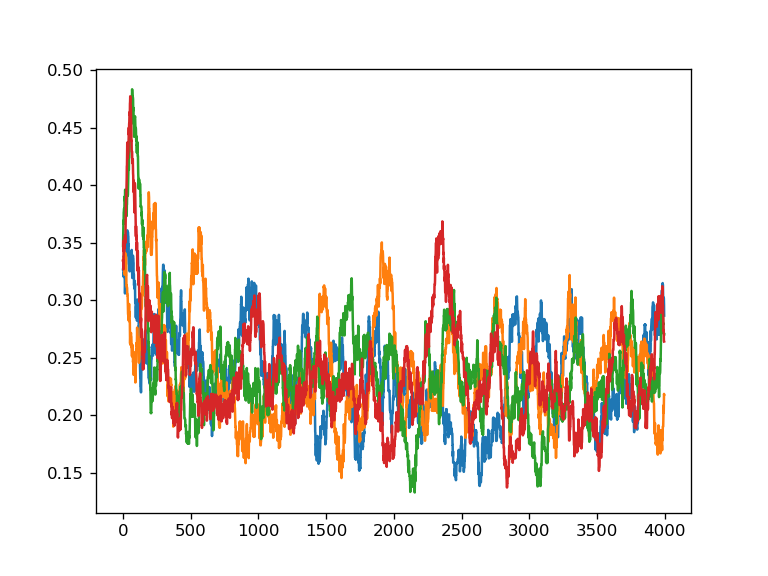

In [16]:
pyplot.figure(dpi=120)
for i in range(nchains):
    arr = sampler.acceptance['acceptance_ratio'][i, :]
    arr[arr > 1] = 1.
    pyplot.plot(moving_average(arr, n=100))
pyplot.show()

## Plot the posterior
Let's create a scatter plot of the posterior. For this, we'll need to throw out some earlier samples for the burn-in period; we'll just assume the first-half of the chains were burn in. We also need to calculate the autocorrelation length of the chains in order to get independent samples.

In [17]:
def calculate_acf(data):
    """Calculates the autocorrelation of some data"""
    # zero the mean
    data = data - data.mean()
    # zero-pad to 2 * nearest power of 2
    newlen = int(2**(1+numpy.ceil(numpy.log2(len(data)))))
    x = numpy.zeros(newlen)
    x[:len(data)] = data[:]
    # correlate
    acf = numpy.correlate(x, x, mode='full')
    # drop corrupted region
    acf = acf[len(acf)//2:]
    # normalize
    acf /= acf[0]
    return acf

def calculate_acl(data):
    """Calculates the autocorrelation length of some data.
    
    Algorithm used is from:
    N. Madras and A.D. Sokal, J. Stat. Phys. 50, 109 (1988).
    """
    # calculate the acf
    acf = calculate_acf(data)
    # now the ACL: Following from Sokal, this is estimated
    # as the first point where M*tau[k] <= k, where
    # tau = 2*cumsum(acf) - 1, and M is a tuneable parameter,
    # generally chosen to be = 5 (which we use here)
    m = 5
    cacf = 2.*numpy.cumsum(acf) - 1.
    win = m * cacf <= numpy.arange(len(cacf))
    if win.any():
        acl = int(numpy.ceil(cacf[numpy.where(win)[0][0]]))
    else:
        # data is too short to estimate the ACL, just choose
        # the length of the data
        acl = len(data)
    return acl

Since the chains are completely independent of each other, we can calculate the ACL separately for each chain. However, if you'd like to be more conservative, you can also just take the max over all of the chains.

In [18]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
stats = sampler.stats['logl'] + sampler.stats['logp']
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
thinned_arrays = {'x': [], 'y': []}
thinned_stats = []
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sx = samples['x'][ii, burnin_iter:]
    sy = samples['y'][ii, burnin_iter:]
    sz = stats[ii, burnin_iter:]
    # compute the acl for each parameter
    aclx = calculate_acl(sx)
    acly = calculate_acl(sy)
    acl = max(aclx, acly)
    acls[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays['x'].append(sx[::-1][::acl][::-1])
    thinned_arrays['y'].append(sy[::-1][::acl][::-1])
    thinned_stats.extend(sz[::-1][::acl][::-1])
# the ACL of each chain:
print(acls)

[ 9 14 11  9]


In [19]:
# create a flattened posterior array
posterior = {'x': numpy.concatenate(thinned_arrays['x']),
             'y': numpy.concatenate(thinned_arrays['y'])}
print("Number of independent samples:", posterior['x'].size)

Number of independent samples: 790


<IPython.core.display.Javascript object>


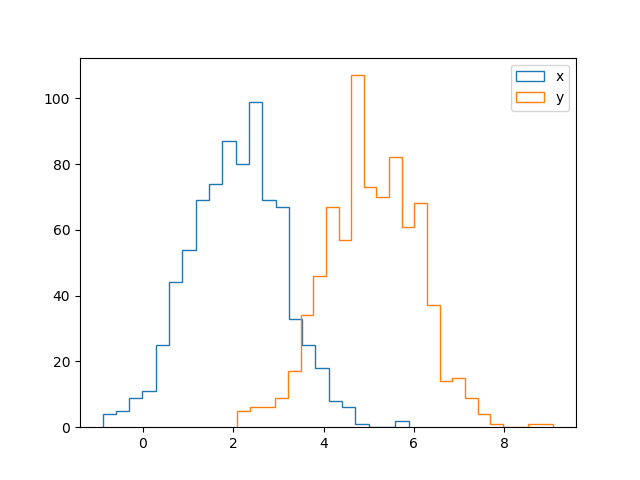

In [20]:
# histogram them
fig, ax = pyplot.subplots()
ax.hist(posterior['x'], bins='auto', histtype='step', label='x')
ax.hist(posterior['y'], bins='auto', histtype='step', label='y')
ax.legend()
fig.show()

Make a plot of the posterior

<IPython.core.display.Javascript object>


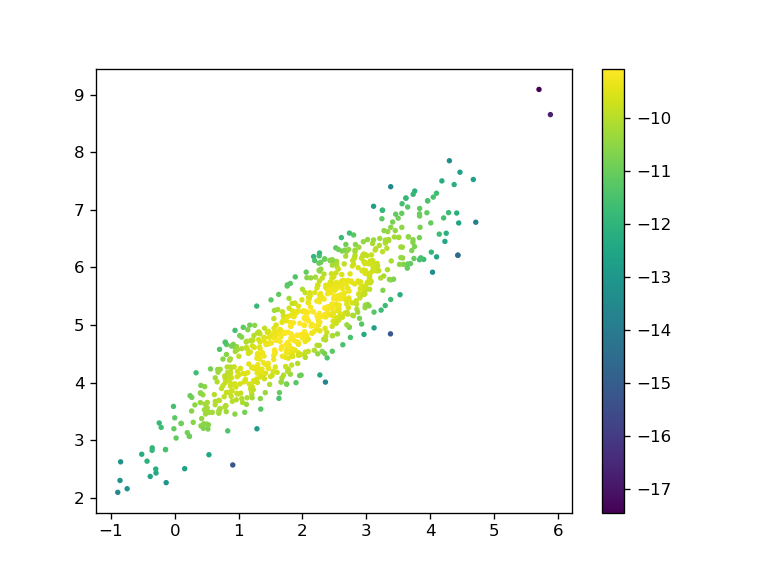

In [21]:
# fig, ax = pyplot.subplots()
pyplot.figure(dpi=120)
pyplot.scatter(posterior['x'], posterior['y'], c=thinned_stats, s=5)
pyplot.colorbar()
pyplot.show()

Let's check the mean and variance of our estimated posterior. These should be $\bar{x} \approx 2, \sigma^2_{x} \approx 1$ and $\bar{y} \approx 5, \sigma^2_{y} \approx 1, \sigma^2_{xy} \approx 0.9$:

In [22]:
arr = numpy.array([posterior[p] for p in posterior.keys()])

print('x mean: {:.4f}, y mean: {:.4f}'.format(arr.mean(axis=-1)[0], arr.mean(axis=-1)[1]))
print('estimated covariance matrix:')
print(numpy.cov(arr))

x mean: 2.0748, y mean: 5.0753
estimated covariance matrix:
[[1.03793682 0.93585924]
 [0.93585924 1.02684303]]
